# You will find SARSA under the Reinforcement Learning branch of ML algorithms within the group of Value-based methods

When working with enumerated states, then the count of classes in each dimension in which state can vary multiplies out to get the total state space "volume". It is valid for the taxi to be in any location on the grid (25), for the passenger to in any of 5 locations at that time (including in the taxi or in some location that they did not want to be dropped in), and for the passenger's destination to be any of the four special locations. These values are all independent and could occur in any combination. Hence 25 * 5 * 4 = 500 total states.

The objective of the game is for the taxi to pick up a passenger (see a person) from a pick-up location, which can be either of the four colour squares and then take the passenger to a drop-off location (see a building), which also can be either of the four colour squares.

The default game rewards are as follows:

-1 per step unless another reward is triggered
+20 for delivering a passenger
-10 for executing “pick-up” and “drop-off” actions illegally

In [2]:
import numpy as np
print('numpy: %s' % np.__version__) # print version

# Note, need to 'pip install gym', and 'pip install gym[toy_text]' 
# or use 'pip install gym\[toy_text\]' if zsh does not recongize the other command
import gym # for simulated environments
print('gym: %s' % gym.__version__) # print version

import matplotlib
import matplotlib.pyplot as plt # for displaying environment states
print('matplotlib: %s' % matplotlib.__version__) # print version
from IPython import display # for displaying environment states

numpy: 1.26.1
gym: 0.26.2
matplotlib: 3.4.3


Next, we set up a Taxi-v3 environment:

In [18]:
# Setup the environment
env = gym.make(id='Taxi-v3', # choose one of the existing environments
               max_episode_steps=None, # default=None, Maximum length of an episode (TimeLimit wrapper).
               autoreset=False, # default=None, Whether to automatically reset the environment after each episode (AutoResetWrapper).
               disable_env_checker=None, # default=None, If to run the env checker
               render_mode = 'rgb_array' # The set of supported modes varies per environment. (And some third-party environments may not support rendering at all.)
              )

In [19]:
# Observation and action space 
state_obs_space = env.observation_space # Returns sate(observation) space of the environment.
action_space = env.action_space # Returns action space of the environment.
print("State(Observation) space:", state_obs_space)
print("Action space:", action_space)

State(Observation) space: Discrete(500)
Action space: Discrete(6)


total states: 25 * 5 * 4 = 500.
Meanwhile, the actions are:

0: move south
1: move north
2: move east
3: move west
4: pick-up a passenger
5: drop-off a passenger

Model training
With the setup complete, let’s use SARSA to find the best policy(𝜋) for our agent to follow in this game.

In [20]:
# SARSA parameters
alpha = 0.1   # learning rate
gamma = 0.95  # discount factor

# Training parameters
n_episodes = 100000  # number of episodes to use for training
n_max_steps = 100   # maximum number of steps per episode

# Exploration / Exploitation parameters
start_epsilon = 1.0  # start training by selecting purely random actions
min_epsilon = 0.0   # the lowest epsilon allowed to decay to
decay_rate = 0.00001   # epsilon will gradually decay so we do less exploring and more exploiting as Q-function improves

To balance exploration vs exploitation, we will vary epsilon throughout training. We will start with epsilon=1 (pure exploration) and decay epsilon with every episode to gradually move from pure exploration to exploitation.

Next, let’s initialise the Q-table. As we’ve seen in the previous section, it will be a 500 x 6 table with rows representing states and columns representing actions. We initialise the Q-table with all 0’s since we do not know how valuable each state is before we start the training.

In [21]:
# Initial Q-table
# Our Q-table is a matrix of state(observation) space x action space, i.e., 500 x 6
Qtable = np.zeros((env.observation_space.n, env.action_space.n))

# Show
Qtable

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

500 possible states and 6 possible actions. 

In [22]:
Qtable.shape

(500, 6)

start_epsilon = 1.0  # start training by selecting purely random actions

In [23]:
#action selection. 
# This is our acting policy (epsilon-greedy), which selects an action for exploration/exploitation during training
def epsilon_greedy(Qtable, state, epsilon):
    # Generate a random number and compare to epsilon, if lower then explore, otherwise exploit
    randnum = np.random.uniform(0, 1)
    if randnum < epsilon:
        action = env.action_space.sample()    # explore. Random move. 
    else:
        action = np.argmax(Qtable[state, :])  # exploit
    return action

In [24]:
# This function is to update the Qtable.
# It is also based on epsilon-greedy approach because the next_action is decided by epsilon-greedy policy
def update_Q(Qtable, state, action, reward, next_state, next_action):
    # 𝑄(𝑆𝑡,𝐴𝑡)=𝑄(𝑆𝑡,𝐴𝑡)+𝛼[𝑅𝑡+1+𝛾𝑄(𝑆𝑡+1,𝐴𝑡+1)−𝑄(𝑆𝑡,𝐴𝑡)]
    Qtable[state][action] = Qtable[state][action] + alpha * (reward + gamma * (Qtable[next_state][next_action]) - Qtable[state][action])
    return Qtable

In [25]:
# This function (greedy) will return the action from Qtable when we do evaluation
def eval_greedy(Qtable, state):
    action = np.argmax(Qtable[state, :])
    return action

# If you look closely at the update_Q function, you will see that it contains the SARSA algorithm equation.

In [26]:
def train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable):
    for episode in range(n_episodes):
        
        # Reset the environment at the start of each episode
        #at the start of each episode, the locations of a taxi, a passenger, and a drop-off change. 
        state, info = env.reset()
        t = 0
        done = False
        
        # Calculate epsilon value based on decay rate
        #if you check here the -decay_rate*episode is increasing because there are 100.000 episodes. 
        #the lower the epsilon the most the random number will be > epsilon and the agent will do more exploitation
        #instead of exploration. 
        #min_epsilon = 0.0
        #at the beginning the taxi starts exploring the environment since the decay_rate*episode part is always going to be low.
        epsilon = max(min_epsilon, (start_epsilon - min_epsilon)*np.exp(-decay_rate*episode))
        
        # Choose an action using previously defined epsilon-greedy policy
        action = epsilon_greedy(Qtable, state, epsilon)
        
        for t in range(n_max_steps):
            
            # Perform the action in the environment, get reward and next state
            next_state, reward, done, _, info = env.step(action)
            
            # Choose next action
            next_action=epsilon_greedy(Qtable, next_state, epsilon)
            
            # Update Q-table
            Qtable = update_Q(Qtable, state, action, reward, next_state, next_action)
            
            # Update current state 
            state = next_state
            action = next_action
            
            # Finish the episode when done=True, i.e., reached the goal or . 
            if done:
                break
                
    # Return final Q-table
    return Qtable

In [27]:
# Train
Qtable = train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable)

# Show Q-table
Qtable

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [-15.72656244, -13.98278324, -14.64984612, -13.43099894,
        -11.20181346, -23.26544679],
       [ -7.28177857,  -1.76522268,  -7.37198859,  -4.52339121,
          0.85897516, -12.91097786],
       ...,
       [ -2.83829229,   2.15223512,  -1.27164708,  -5.36668289,
        -13.36244241,  -9.53120045],
       [-17.14007584, -14.73293606, -17.09261737, -10.78699495,
        -27.33223218, -24.16682613],
       [ 10.85573355,   5.18836954,  11.23248774,  14.22483479,
          1.00884546,   2.35435184]])

Evaluation
Since it is difficult to judge the result by inspecting the Q-table, let’s run 10,000 episodes to evaluate the agent’s performance. We will use statistics such as mean, standard deviation and min/max of the rewards alongside the distribution chart.

In [11]:
#n_max_steps = 100 

The default game rewards are as follows:

-1 per step unless another reward is triggered
+20 for delivering a passenger
-10 for executing “pick-up” and “drop-off” actions illegally

In [28]:
def evaluate_agent(n_max_steps, n_eval_episodes, Qtable):
    # Initialize an empty list to store rewards for each episode
    episode_rewards=[]
    
    # Evaluate for each episode
    for episode in range(n_eval_episodes):
        
        # Reset the environment at the start of each episode
         #at the start of each episode, the locations of a taxi, a passenger, and a drop-off change. 
        state, info = env.reset()
        t = 0
        done = False
        tot_episode_reward = 0
        
        for t in range(n_max_steps):
            
            # Use greedy policy to evaluate
            action = eval_greedy(Qtable, state)

            # Pass action into step function
            next_state, reward, done, _, info = env.step(action)

            # Sum episode rewards
            tot_episode_reward = tot_episode_reward + reward

            # Update current state 
            state = next_state
            
            # Finish the episode when done=True, i.e., reached the goal or does the maximum step without reaching the goal.
            if done:
                break
                
        episode_rewards.append(tot_episode_reward)
        
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward, episode_rewards

Mean Reward = 7.93 +/- 2.59
Min = 3.0 and Max 15.0


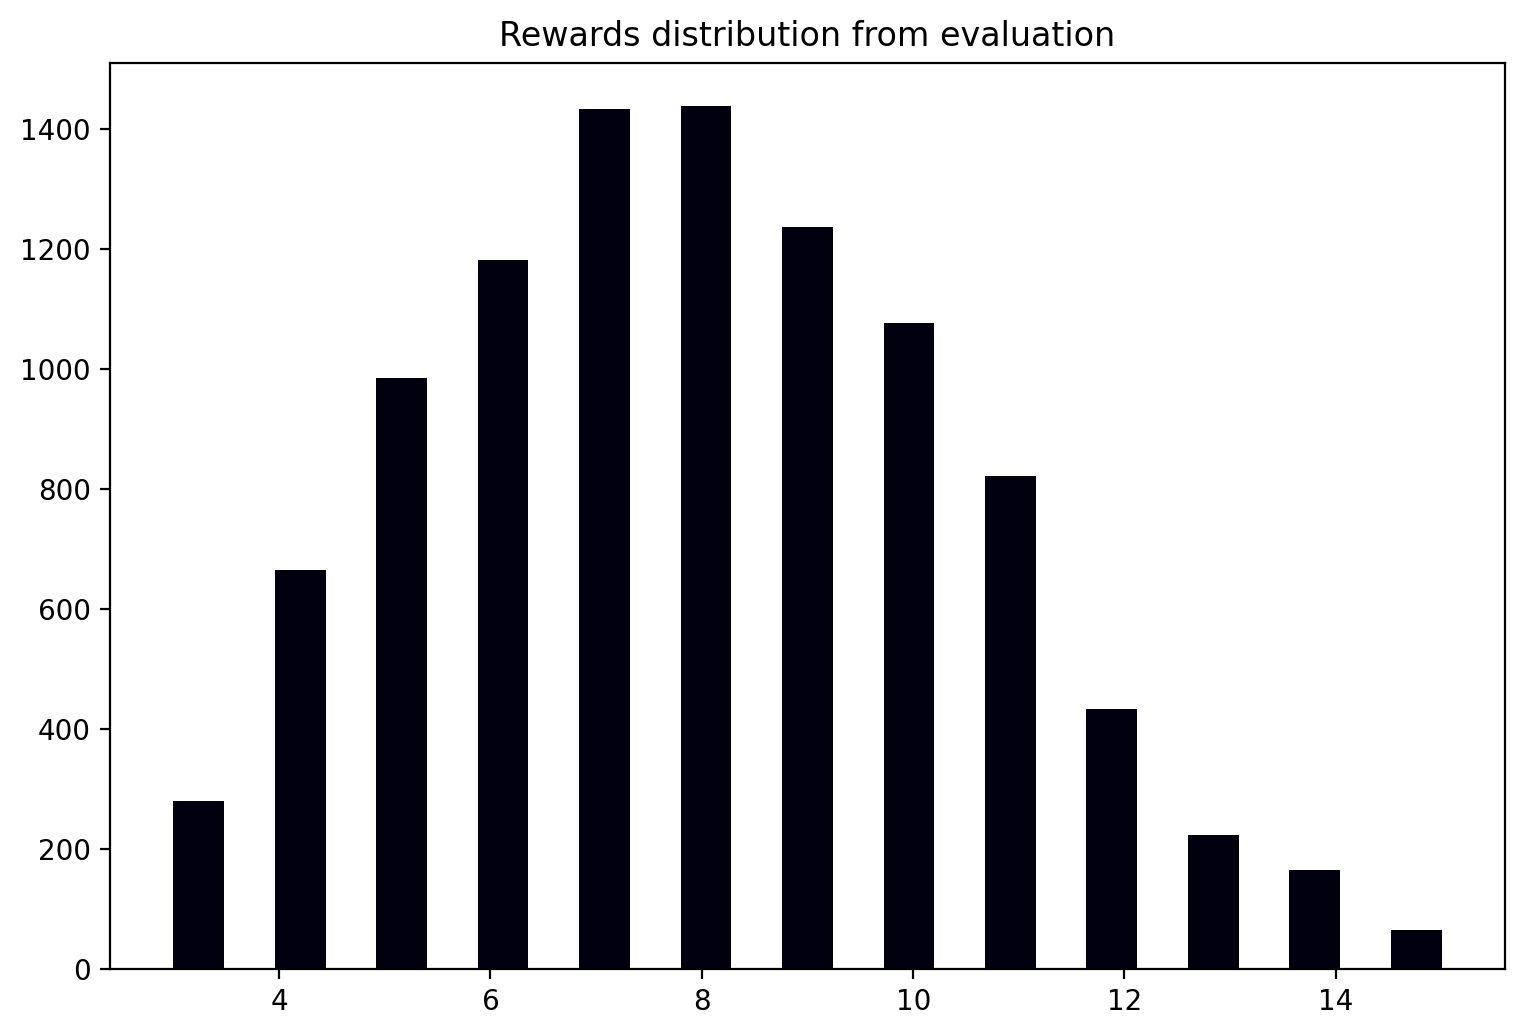

In [29]:
# Evaluate
n_eval_episodes=10000
mean_reward, std_reward, episode_rewards = evaluate_agent(n_max_steps, n_eval_episodes, Qtable)

# Print evaluation results
print(f"Mean Reward = {mean_reward:.2f} +/- {std_reward:.2f}")
print(f"Min = {min(episode_rewards):.1f} and Max {max(episode_rewards):.1f}")
#the y-axis are the number of episodes. For example 1400 out of the 10000 have reward of 7.
# Show the distribution of rewards obtained from evaluation
plt.figure(figsize=(9,6), dpi=200)
plt.title(label='Rewards distribution from evaluation', loc='center')
plt.hist(episode_rewards, bins=25, color='#00000f')
plt.show()

The default game rewards are as follows:

-1 per step unless another reward is triggered
+20 for delivering a passenger
-10 for executing “pick-up” and “drop-off” actions illegally

The average reward from 10,000 episodes is 7.96 +/- 2.59. It indicates some variation in rewards, but that is because at the start of each episode, the locations of a taxi, a passenger, and a drop-off change. Hence, each time we require a different number of steps to complete the task, so we don’t always receive the same reward 

The minimum reward is 3, which confirms that we always get a positive reward. Looking at the map, we can easily calculate that it takes 17 steps (16 moves + 1 pick-up action) if we initialised the taxi and passenger at opposite corners with a drop-off location being the same corner as the taxi’s original position. Hence, choosing the perfect route for a most distant scenario would result in a reward of 3 (20 - 17).

The maximum reward is 15, so let’s see why we cannot expect any higher. If a passenger is initialised at the drop-off location, the episode ends immediately (i.e., not a valid scenario, so there is no hope for scoring 20). Hence, the best case we can hope for is when the passenger and taxi are initialised in the same location. If we take the two closest colour squares (Red and Yellow), the agent would use 5 moves (1 to pick up and 4 to move) to transport the passenger from the pick-up location to the drop-off location, giving us the maximum possible reward of 15 (20 - 5).

# The reward distribution chart indicates a close-to-normal distribution of rewards. So, while it does not prove that we have an optimal policy, it suggests that the agent is making rational moves.

Mean Reward = 7.93 +/- 2.59
Min = 3.0 and Max 15.0


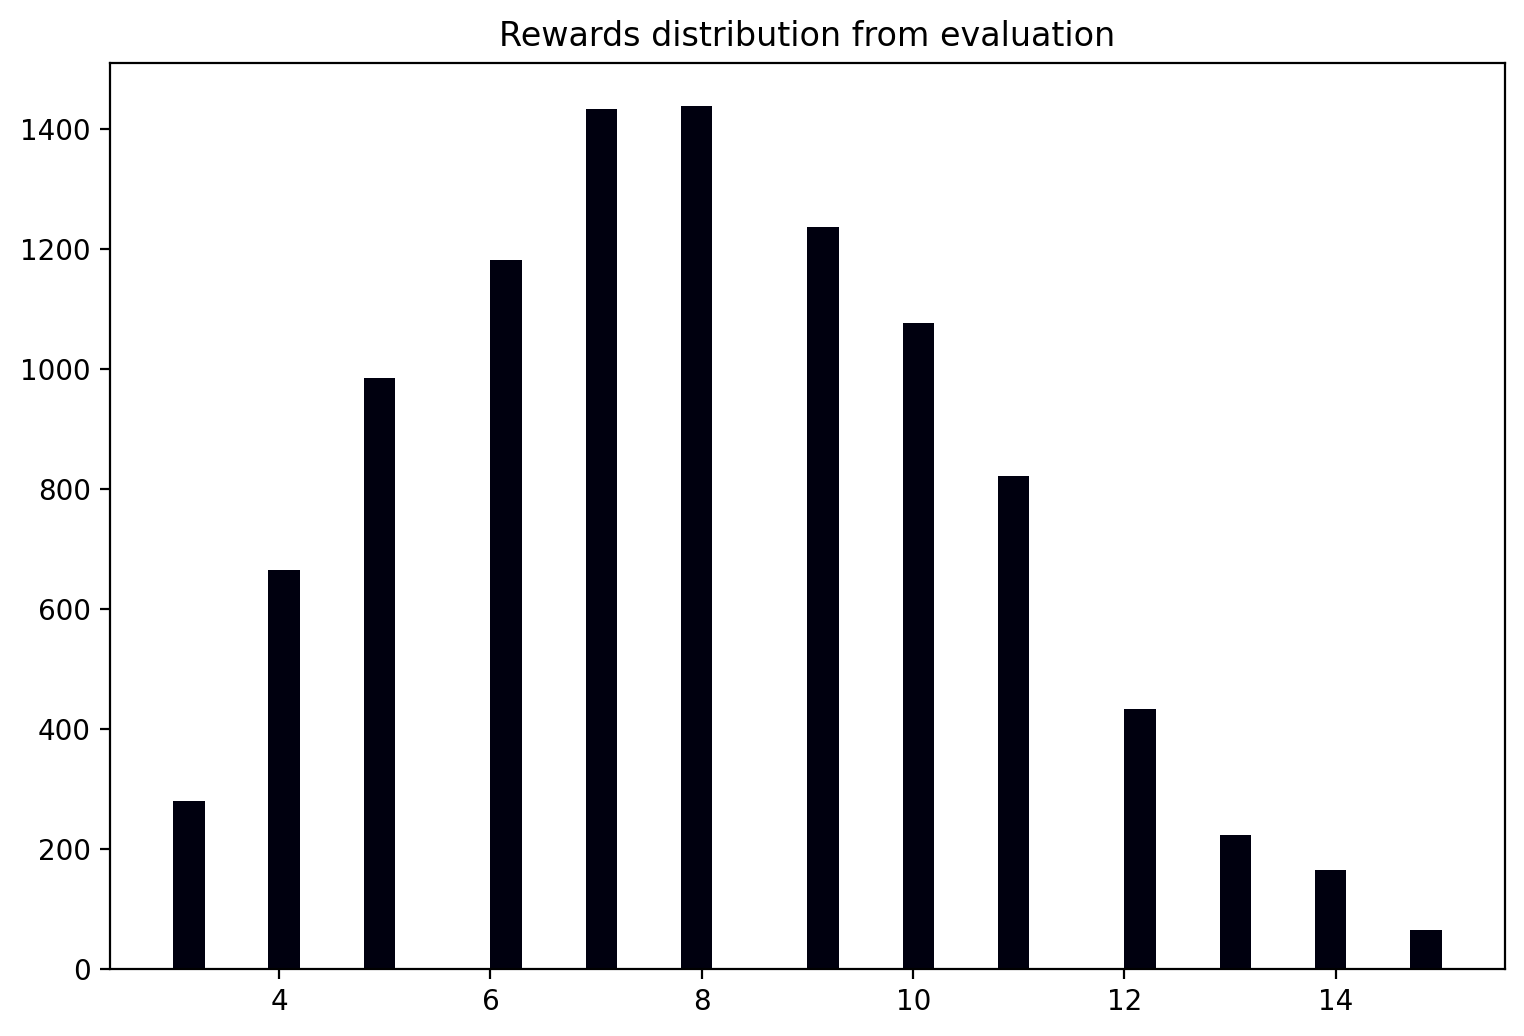

In [31]:
# Print evaluation results
print(f"Mean Reward = {mean_reward:.2f} +/- {std_reward:.2f}")
print(f"Min = {min(episode_rewards):.1f} and Max {max(episode_rewards):.1f}")
#the y-axis are the number of episodes. For example 1400 out of the 10000 have reward of 7.
# Show the distribution of rewards obtained from evaluation
plt.figure(figsize=(9,6), dpi=200)
plt.title(label='Rewards distribution from evaluation', loc='center')
plt.hist(episode_rewards, bins=40, color='#00000f')
plt.show()

# it does not matter how many BINS you use to create the histogram. It always gives a total of 13 possible rewards scenarios. 

# Since the Min rewards is 3.00 we see that after training 10.000 episodes with different possible states, 500, the agent has learnt to pick up the passenger and take the optimal states to drop off the agent to the destination. 

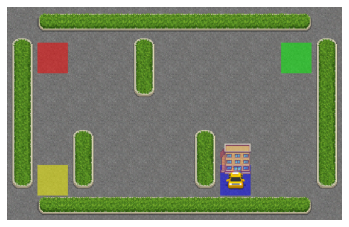

In [32]:
# Reset environment to initial state
state, info = env.reset()

# Cycle through 50 steps redering and displaying environment state each time
for _ in range(50):
    
    # Render and display current state of the environment
    plt.imshow(env.render()) # render current state and pass to pyplot
    plt.axis('off')
    display.display(plt.gcf()) # get current figure and display
    display.clear_output(wait=True) # clear output before showing the next frame
    
    # Use greedy policy to evaluate
    action = eval_greedy(Qtable, state)
    
    # Pass action into step function
    state, reward, done, _, info = env.step(action)
    
    # Reset environment when done=True, i.e. when the agent falls into a Hole (H) or reaches the Goal (G)
    if done:
        # Render and display final state of the environment
        plt.imshow(env.render()) # render current state and pass to pyplot
        plt.axis('off')
        display.display(plt.gcf()) # get current figure and display
        display.clear_output(wait=True) # clear output before showing the next frame
        state, info = env.reset()

env.close()

# Let's do the same game environment but this time using Q-learning:

In [33]:
# This is our updating policy (greedy) 
# i.e., always select the action with the highest value for that state: np.max(Qtable[next_state])
def update_Q_QLearning(Qtable, state, action, reward, next_state):
    # Q(S_t,A_t) = Q(S_t,A_t) + alpha [R_t+1 + gamma * max Q(S_t+1,a) - Q(S_t,A_t)]
    Qtable[state][action] = Qtable[state][action] + alpha * (reward + gamma * np.max(Qtable[next_state]) - Qtable[state][action])
    return Qtable

In [36]:
def train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable):
    for episode in range(n_episodes):
        
        # Reset the environment at the start of each episode
        #at the start of each episode, the locations of a taxi, a passenger, and a drop-off change. 
        state, info = env.reset()
        t = 0
        done = False
        
        # Calculate epsilon value based on decay rate
        #if you check here the -decay_rate*episode is increasing because there are 100.000 episodes. 
        #the lower the epsilon the most the random number will be > epsilon and the agent will do more exploitation
        #instead of exploration. 
        #min_epsilon = 0.0
        #at the beginning the taxi starts exploring the environment since the decay_rate*episode part is always going to be low.
        epsilon = max(min_epsilon, (start_epsilon - min_epsilon)*np.exp(-decay_rate*episode))
        
        # Choose an action using previously defined epsilon-greedy policy
        action = epsilon_greedy(Qtable, state, epsilon)
        
        for t in range(n_max_steps):
            
            # Perform the action in the environment, get reward and next state
            next_state, reward, done, _, info = env.step(action)
            
            # Choose next action
            next_action=epsilon_greedy(Qtable, next_state, epsilon)
            
            # Update Q-table
            Qtable = update_Q_QLearning(Qtable, state, action, reward, next_state)
            
            # Update current state 
            state = next_state
            action = next_action
            
            # Finish the episode when done=True, i.e., reached the goal or . 
            if done:
                break
                
    # Return final Q-table
    return Qtable

In [37]:
# Train
Qtable = train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable)

# Show Q-table
Qtable

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 2.75200369,  3.94947757,  2.75200369,  3.94947757,  5.20997639,
        -5.05052243],
       [ 7.93349184,  9.40367562,  7.93349184,  9.40367562, 10.9512375 ,
         0.40367562],
       ...,
       [10.9512375 , 12.58025   , 10.9512375 ,  9.40367562,  1.9512375 ,
         1.9512375 ],
       [ 5.20997639,  6.53681725,  5.20997639,  6.53681725, -3.79002361,
        -3.79002361],
       [16.1       , 14.295     , 16.1       , 18.        ,  7.1       ,
         7.1       ]])

In [38]:
def evaluate_agent(n_max_steps, n_eval_episodes, Qtable):
    # Initialize an empty list to store rewards for each episode
    episode_rewards=[]
    
    # Evaluate for each episode
    for episode in range(n_eval_episodes):
        
        # Reset the environment at the start of each episode
         #at the start of each episode, the locations of a taxi, a passenger, and a drop-off change. 
        state, info = env.reset()
        t = 0
        done = False
        tot_episode_reward = 0
        
        for t in range(n_max_steps):
            
            # Use greedy policy to evaluate
            action = eval_greedy(Qtable, state)

            # Pass action into step function
            next_state, reward, done, _, info = env.step(action)

            # Sum episode rewards
            tot_episode_reward = tot_episode_reward + reward

            # Update current state 
            state = next_state
            
            # Finish the episode when done=True, i.e., reached the goal or does the maximum step without reaching the goal.
            if done:
                break
                
        episode_rewards.append(tot_episode_reward)
        
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward, episode_rewards

Mean Reward = 7.95 +/- 2.57
Min = 3.0 and Max 15.0


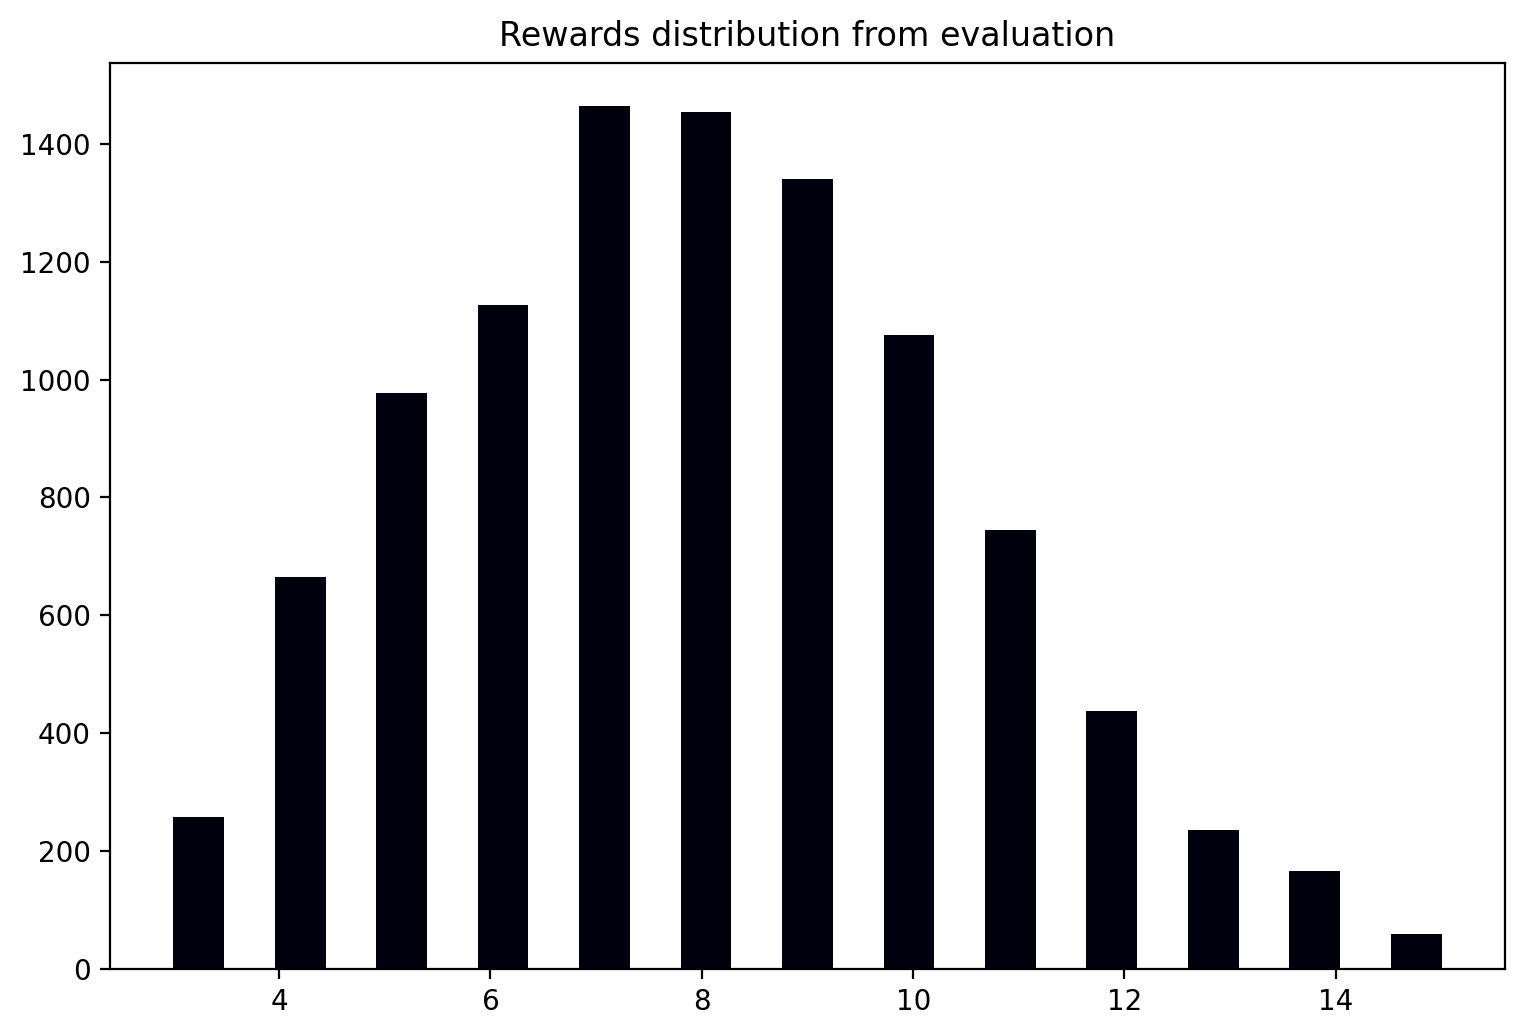

In [39]:
# Evaluate Q-Learning
n_eval_episodes=10000
mean_reward, std_reward, episode_rewards = evaluate_agent(n_max_steps, n_eval_episodes, Qtable)

# Print evaluation results
print(f"Mean Reward = {mean_reward:.2f} +/- {std_reward:.2f}")
print(f"Min = {min(episode_rewards):.1f} and Max {max(episode_rewards):.1f}")
#the y-axis are the number of episodes. For example 1400 out of the 10000 have reward of 7.
# Show the distribution of rewards obtained from evaluation
plt.figure(figsize=(9,6), dpi=200)
plt.title(label='Rewards distribution from evaluation', loc='center')
plt.hist(episode_rewards, bins=25, color='#00000f')
plt.show()

# Very similar Results with both methods: SARSA Results: Mean Reward = 7.93 +/- 2.59. Q-Learning Results: Mean Reward = 7.95 +/- 2.57

# ---------------------------------------------------------------------------------------------------------------

# The tutorial below will use the SARSA algorithm to solve the FrozenLake

In [1]:
import numpy as np
print('numpy: %s' % np.__version__) # print version

# Note need to 'pip install gym', and 'pip install gym[toy_text]' 
                                  # or 'pip install gym\[toy_text\]' if zsh does nor recongize the first command
import gym # for simulated environments
print('gym: %s' % gym.__version__) # print version

import matplotlib
import matplotlib.pyplot as plt # for displaying environment states
print('matplotlib: %s' % matplotlib.__version__) # print version

from IPython import display # for displaying environment states
import time # for slowing down rendering of states by adding small time delays

numpy: 1.20.3
gym: 0.26.2
matplotlib: 3.4.3


In [2]:
# Setup environment
env = gym.make(id='FrozenLake-v1', # Choose one of the existing environments
               desc=None, # Used to specify custom map for frozen lake. E.g., desc=["SFFF", "FHFH", "FFFH", "HFFG"].
               map_name='4x4', # ID to use any of the preloaded maps. E.g., '4x4', '8x8'
               is_slippery=False, # True/False. If True will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions.
               max_episode_steps=None, # default=None, Maximum length of an episode (TimeLimit wrapper).
               autoreset=False, # default=None, Whether to automatically reset the environment after each episode (AutoResetWrapper).
               disable_env_checker=None, # default=None, If to run the env checker
               render_mode = 'rgb_array' # The set of supported modes varies per environment. (And some third-party environments may not support rendering at all.)
              )

In [3]:
# Show environment description (map) as an array
print("Environment Array: ")
print(env.desc)

# Observation and action space 
state_obs_space = env.observation_space # Returns sate(observation) space of the environment.
action_space = env.action_space # Returns action space of the environment.
print("State(Observation) space:", state_obs_space)
print("Action space:", action_space)

Environment Array: 
[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]
State(Observation) space: Discrete(16)
Action space: Discrete(4)


In [4]:
# Q-function parameters
alpha = 0.7   # learning rate
gamma = 0.95  # discount factor

# Training parameters
n_episodes = 10000  # number of episodes to use for training
n_max_steps = 100   # maximum number of steps per episode

# Exploration / Exploitation parameters
start_epsilon = 1.0  # start training by selecting purely random actions
min_epsilon = 0.05   # the lowest epsilon allowed to decay to
decay_rate = 0.001   # epsilon will gradually decay so we do less exploring and more exploiting as Q-function improves

In [5]:
#action selection. 
# This is our acting policy (epsilon-greedy), which selects an action for exploration/exploitation during training
def epsilon_greedy(Qtable, state, epsilon):
    # Generate a random number and compare to epsilon, if lower then explore, otherwise exploit
    randnum = np.random.uniform(0, 1)
    if randnum < epsilon:
        action = env.action_space.sample()    # explore
    else:
        action = np.argmax(Qtable[state, :])  # exploit
    return action

In [6]:
# This function is to update the Qtable.
# It is also based on epsilon-greedy approach because the next_action is decided by epsilon-greedy policy
def update_Q(Qtable, state, action, reward, next_state, next_action):
    # 𝑄(𝑆𝑡,𝐴𝑡)=𝑄(𝑆𝑡,𝐴𝑡)+𝛼[𝑅𝑡+1+𝛾𝑄(𝑆𝑡+1,𝐴𝑡+1)−𝑄(𝑆𝑡,𝐴𝑡)]
    Qtable[state][action] = Qtable[state][action] + alpha * (reward + gamma * (Qtable[next_state][next_action]) - Qtable[state][action])
    return Qtable

In [7]:
# This function (greedy) will return the action from Qtable when we do evaluation
def eval_greedy(Qtable, state):
    action = np.argmax(Qtable[state, :])
    return action

In [8]:
def train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable):
    for episode in range(n_episodes):
        
        # Reset the environment at the start of each episode
        #at the start of each episode, the locations of a taxi, a passenger, and a drop-off change. 
        state, info = env.reset()
        t = 0
        done = False
        
        # Calculate epsilon value based on decay rate
        #if you check here the -decay_rate*episode is increasing because there are 100.000 episodes. 
        #the lower the epsilon the most the random number will be > epsilon and the agent will do more exploitation
        #instead of exploration. 
        #min_epsilon = 0.0
        epsilon = max(min_epsilon, (start_epsilon - min_epsilon)*np.exp(-decay_rate*episode))
        
        # Choose an action using previously defined epsilon-greedy policy
        action = epsilon_greedy(Qtable, state, epsilon)
        
        for t in range(n_max_steps):
            
            # Perform the action in the environment, get reward and next state
            next_state, reward, done, _, info = env.step(action)
            
            # Choose next action
            next_action=epsilon_greedy(Qtable, next_state, epsilon)
            
            # Update Q-table
            Qtable = update_Q(Qtable, state, action, reward, next_state, next_action)
            
            # Update current state 
            state = next_state
            action = next_action
            
            # Finish the episode when done=True, i.e., reached the goal or . 
            if done:
                break
                
    # Return final Q-table
    return Qtable

In [9]:
# Initial Q-table
# Our Q-table is a matrix of state(observation) space x action space, i.e., 16 x 4
Qtable = np.zeros((env.observation_space.n, env.action_space.n))

# Show
Qtable

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [10]:
Qtable.shape

(16, 4)

In [11]:
# Train
Qtable = train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable)

# Show Q-table
Qtable

array([[0.30324837, 0.73053055, 0.23204118, 0.30735226],
       [0.24510228, 0.        , 0.81445959, 0.29644371],
       [0.06670608, 0.85737079, 0.22012982, 0.24972838],
       [0.21552979, 0.        , 0.2163723 , 0.21921393],
       [0.5630216 , 0.81381894, 0.        , 0.34812859],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.8262659 , 0.        , 0.25536629],
       [0.        , 0.        , 0.        , 0.        ],
       [0.10179643, 0.        , 0.85729748, 0.2534501 ],
       [0.46225993, 0.27075   , 0.90249611, 0.        ],
       [0.50055335, 0.95      , 0.        , 0.62712257],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.89730052, 0.95      , 0.59267005],
       [0.69086375, 0.95      , 1.        , 0.67805051],
       [0.        , 0.        , 0.        , 0.        ]])

In [12]:
def evaluate_agent(n_max_steps, n_eval_episodes, Qtable):
    # Initialize an empty list to store rewards for each episode
    episode_rewards=[]
    
    # Evaluate for each episode
    for episode in range(n_eval_episodes):
        
        # Reset the environment at the start of each episode
         #at the start of each episode, the locations of a taxi, a passenger, and a drop-off change. 
        state, info = env.reset()
        t = 0
        done = False
        tot_episode_reward = 0
        
        for t in range(n_max_steps):
            
            # Use greedy policy to evaluate
            action = eval_greedy(Qtable, state)

            # Pass action into step function
            next_state, reward, done, _, info = env.step(action)

            # Sum episode rewards
            tot_episode_reward = tot_episode_reward + reward

            # Update current state 
            state = next_state
            
            # Finish the episode when done=True, i.e., reached the goal or does the maximum step without reaching the goal.
            if done:
                break
                
        episode_rewards.append(tot_episode_reward)
        
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward, episode_rewards

In [14]:
# Call the above evaluation function and display the results:
n_eval_episodes=100 # evaluate over 100 episodes
mean_reward, std_reward,episode_rewards = evaluate_agent(n_max_steps, n_eval_episodes, Qtable)
print(f"Mean Reward & Std_Deviation = {mean_reward:.2f} +/- {std_reward:.2f}")

Mean Reward & Std_Deviation = 1.00 +/- 0.00


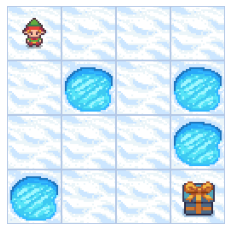

In [17]:
# Cycle through 19 steps redering and displaying environment state each time
state, info = env.reset()
for _ in range(19):
    
    # Render and display current state of the environment
    plt.imshow(env.render()) # render current state and pass to pyplot
    plt.axis('off')
    display.display(plt.gcf()) # get current figure and display
    display.clear_output(wait=True) # clear output before showing the next frame
    
    # Use greedy policy to evaluate
    action = eval_greedy(Qtable, state)
    
    # Pass action into step function
    state, reward, done, _, info = env.step(action)

    # Wait a little bit before the next frame
    time.sleep(0.2)
    
    # Reset environment when done=True, i.e. when the agent falls into a Hole (H) or reaches the Goal (G)
    if done:
        # Render and display final state of the environment
        plt.imshow(env.render()) # render current state and pass to pyplot
        plt.axis('off')
        display.display(plt.gcf()) # get current figure and display
        display.clear_output(wait=True) # clear output before showing the next frame
        state, info = env.reset()

env.close()

# The agent has learnt the best path in all the 19 steps using the Q updated values creating in the training process to know where to move. 